In [1184]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib.dates as mdates # type: ignore
import matplotlib.ticker as ticker # type: ignore
from matplotlib.axis import Axis # type: ignore
import datetime as dt 

import time
start = time.time()

In [1185]:
def get_data2(filename):    
    data = pd.read_csv(filename) #, names=["Interval","kWh"])
    return data
    
def conso_byhour(day):
    ''' 
    display conso by hour for the chosen day
    '''
    conso_day=conso_data[conso_data['days']==day].copy()  # type: ignore # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))

    conso_hours = conso_day.copy()
    conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
    conso_hours#.info()
    # group by hour
    groupedbyhour = conso_hours[['hours','kWh']].groupby('hours', sort=False)
    groupedbyhour.count()
    len(groupedbyhour)
    x = np.arange(1,len(groupedbyhour)+1)

    #groupedbyhour.count().plot(grid=True,xticks=x)
    plt.figure(figsize=(12, 8),facecolor='darkcyan')
    values = groupedbyhour.count().kWh
    #ax = plt.bar(x,groupedbyhour.count().kWh)
    ax = values.plot(kind="bar",color='green',width=.8)
    ax.set_facecolor('antiquewhite')
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) - {day}')
    plt.xlim(-1,len(x)+1)
    plt.xticks(rotation=30);
    
    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in values]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom",
            fontfamily='calibri', fontsize=16, fontweight='bold', color='blue'
        )
    
    
def from_csv(csv_file): 
    ''' save data to csv  '''
    df = pd.read_csv(csv_file)
    return df
    
def to_csv(csv_file, df):
    ''' read data from csv'''
    df.to_csv(csv_file, index=False)


### conso.csv créé par pi4 node-red onglet Linky
#### création de conso_data 

In [1186]:
conso_file = r"\\192.168.0.175\pihome\Documents\conso2.csv"
conso_data = get_data2(conso_file)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2304411 entries, 0 to 2304410
Data columns (total 2 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Interval  int64  
 1   kWh       float64
dtypes: float64(1), int64(1)
memory usage: 35.2 MB


# reduce to 1 million events

In [1187]:
conso_data = conso_data.tail(1000000)
conso_data.reset_index(drop=True, inplace=True)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Interval  1000000 non-null  int64  
 1   kWh       1000000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 15.3 MB


### conversion millisec -> sec

In [1188]:
conso_data['sec']=conso_data['Interval']/1000
conso_data

,Interval,kWh,sec
0,23895,0.15,23.895
1,24766,0.14,24.766
2,24825,0.14,24.825
3,25008,0.14,25.008
4,25158,0.14,25.158
...,...,...,...
999995,2446,1.47,2.446
999996,2449,1.47,2.449
999997,2454,1.47,2.454
999998,2447,1.47,2.447


### conversion Interval -> kWh

In [1189]:
conso_data['Wh']=3600000/conso_data['Interval']
conso_data


,Interval,kWh,sec,Wh
0,23895,0.15,23.895,150.659134
1,24766,0.14,24.766,145.360575
2,24825,0.14,24.825,145.015106
3,25008,0.14,25.008,143.953935
4,25158,0.14,25.158,143.095636
...,...,...,...,...
999995,2446,1.47,2.446,1471.790679
999996,2449,1.47,2.449,1469.987750
999997,2454,1.47,2.454,1466.992665
999998,2447,1.47,2.447,1471.189211


### Cumul Total interval

In [1190]:
conso_data['cumul(ms)']=conso_data['Interval'].cumsum(axis=0)

In [1191]:
l=len(conso_data)-1
cumtime= int(conso_data._get_value(l,'cumul(ms)')*1000)  # convert to microseconds
cumtime

26192943540000

### Calcul de la date de base = now - cumul_interval

In [1192]:
from datetime import datetime, timedelta
now = datetime.now()
# conso.csv dynamique
base = now - timedelta(microseconds=cumtime)
base  # date de début

datetime.datetime(2024, 8, 12, 7, 20, 8, 201401)

In [1193]:
conso_data['cumul(ms)'][conso_data['cumul(ms)'].isna()==True]

Series([], Name: cumul(ms), dtype: int64)

In [1194]:
conso_data.iloc[0]


Interval     23895.000000
kWh              0.150000
sec             23.895000
Wh             150.659134
cumul(ms)    23895.000000
Name: 0, dtype: float64

### Recréer les dates à partir des cumuls par impulsion


In [1195]:
base

datetime.datetime(2024, 8, 12, 7, 20, 8, 201401)

## créer les dates

In [1196]:
# create column 'dates' with time cumulated time from base
conso_data['dates'] = [base + dt.timedelta(microseconds=t*1000) for t in conso_data['cumul(ms)']]
conso_data['dates']

0        2024-08-12 07:20:32.096401
1        2024-08-12 07:20:56.862401
2        2024-08-12 07:21:21.687401
3        2024-08-12 07:21:46.695401
4        2024-08-12 07:22:11.853401
                    ...            
999995   2025-06-11 11:09:01.945401
999996   2025-06-11 11:09:04.394401
999997   2025-06-11 11:09:06.848401
999998   2025-06-11 11:09:09.295401
999999   2025-06-11 11:09:11.741401
Name: dates, Length: 1000000, dtype: datetime64[ns]

### create column 'days' avec format 'dd/mm/yy'


In [1197]:
conso_data['days']= [d.strftime('%d/%m/%y') for d in conso_data['dates']]    
#[str(d.month)+'-'+str(d.day) for d in conso_data['dates']]
conso_data

,Interval,kWh,sec,Wh,cumul(ms),dates,days
0,23895,0.15,23.895,150.659134,23895,2024-08-12 07:20:32.096401,12/08/24
1,24766,0.14,24.766,145.360575,48661,2024-08-12 07:20:56.862401,12/08/24
2,24825,0.14,24.825,145.015106,73486,2024-08-12 07:21:21.687401,12/08/24
3,25008,0.14,25.008,143.953935,98494,2024-08-12 07:21:46.695401,12/08/24
4,25158,0.14,25.158,143.095636,123652,2024-08-12 07:22:11.853401,12/08/24
...,...,...,...,...,...,...,...
999995,2446,1.47,2.446,1471.790679,26192933744,2025-06-11 11:09:01.945401,11/06/25
999996,2449,1.47,2.449,1469.987750,26192936193,2025-06-11 11:09:04.394401,11/06/25
999997,2454,1.47,2.454,1466.992665,26192938647,2025-06-11 11:09:06.848401,11/06/25
999998,2447,1.47,2.447,1471.189211,26192941094,2025-06-11 11:09:09.295401,11/06/25


### save conso_data with dates

In [1198]:
#to_csv(r'../conso_data_with_dates.csv',conso_data)

# tranche journalière


In [1199]:
now = datetime.now()
month = now.month
year = now.year
date = now.day
today = now.strftime('%d/%m/%y')    #str(now.month)+'-'+str(now.day)
here = now.strftime('%H:%M:%S')
today, date, month, year, here

('11/06/25', 11, 6, 2025, '11:09:37')

In [1200]:
conso_day = conso_data[conso_data['days']==today]
# save to file
filename='conso_jour.csv'
conso_day.to_csv(filename)
filename='../conso_jour.csv'
conso_day.to_csv(filename)

In [1201]:
conso_day.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1266 entries, 998734 to 999999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   1266 non-null   int64         
 1   kWh        1266 non-null   float64       
 2   sec        1266 non-null   float64       
 3   Wh         1266 non-null   float64       
 4   cumul(ms)  1266 non-null   int64         
 5   dates      1266 non-null   datetime64[ns]
 6   days       1266 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 79.1+ KB


In [1202]:
end = time.time()
print(end - start)

31.827932834625244


### grouped by days

In [1203]:
# group by day
grouped = conso_data[['days','kWh']].groupby('days', sort=False)
'''conso_graph=[]
for name, group in grouped:
    if name=='01/04/2024':print(group)
    #print("\n", name, len(group)/1000)
    conso_graph.append((name,len(group)/1000))'''
#grouped
# count elements in each group => conso in watts => convert to kW
df_grp = grouped.count()/1000



In [1204]:
data = list(df_grp['kWh'])
print(data)

[2.987, 4.333, 3.907, 3.86, 4.058, 3.765, 3.903, 3.703, 3.269, 3.927, 3.932, 4.39, 3.841, 4.086, 3.814, 3.978, 3.735, 4.007, 3.629, 3.679, 3.501, 3.675, 3.492, 4.16, 3.705, 3.461, 3.563, 3.214, 2.506, 1.795, 1.793, 1.794, 1.795, 2.459, 1.878, 1.788, 1.792, 1.789, 1.82, 1.822, 1.816, 1.817, 1.818, 1.817, 1.815, 1.815, 1.785, 1.786, 1.785, 1.787, 1.782, 1.797, 1.788, 1.79, 1.785, 1.796, 1.802, 1.795, 1.803, 1.796, 1.786, 1.789, 1.785, 1.791, 1.797, 1.79, 1.801, 1.803, 1.795, 1.8, 1.798, 2.74, 3.999, 3.665, 3.9, 3.109, 3.492, 4.02, 3.453, 3.415, 3.974, 3.333, 4.168, 3.111, 4.018, 3.159, 3.341, 3.464, 4.03, 3.286, 3.376, 3.822, 3.229, 3.534, 3.343, 3.876, 3.32, 3.452, 3.723, 4.448, 3.624, 3.869, 3.43, 4.133, 3.488, 3.415, 3.333, 3.848, 3.69, 4.113, 3.537, 3.461, 3.72, 3.177, 3.662, 3.749, 3.32, 3.856, 3.21, 4.075, 3.404, 3.812, 3.999, 3.473, 4.469, 3.227, 3.516, 3.064, 3.241, 3.451, 3.337, 3.374, 3.491, 4.704, 4.4, 3.242, 3.465, 3.701, 3.985, 3.44, 4.476, 4.199, 4.152, 3.642, 3.954, 3.329,

In [1205]:
# save to file
# import pickle
# path = r'kwh_mean.pkl'
# with open(path,'wb') as file:
#     pickle.dump(data, file)

In [1206]:
end = time.time()
print(end - start)

33.06789588928223


### plot function by day
#### show('dd/mm/yy')

In [1207]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # type: ignore
def show(day,pltcolor='darkcyan',bgcolor="ivory"):
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))
    #=[x.hour for x in conso_day['dates']]
    #print(conso_day)
    df = conso_day.set_index('heure')
    here = now.strftime('%H:%M:%S')
    conso_jour=len(df['kWh'])
    here, len(df)/1000, conso_jour

    # consommation d'une journée entière à partir de minuit
    # Set background color of the outer 
    # area of the plt
    #plt.figure(facecolor=fgcolor)
    fig, ax = plt.subplots(facecolor=pltcolor)
    
    major_ticks=300;minor_ticks=100
    ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  # major ticks tous les 15 min
    ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
    # the size of A4 paper
    fig.set_size_inches(10, 5)
    
    # set bg color
    ax.set_facecolor(bgcolor)
    plt.plot(df['kWh'])
    #plt.plot(conso_day['heure'],conso_day['kWh'])
    plt.title(f'Journée du {day} {here} : {conso_jour/1000} kwh')
    plt.grid()
    plt.xticks(rotation=30);


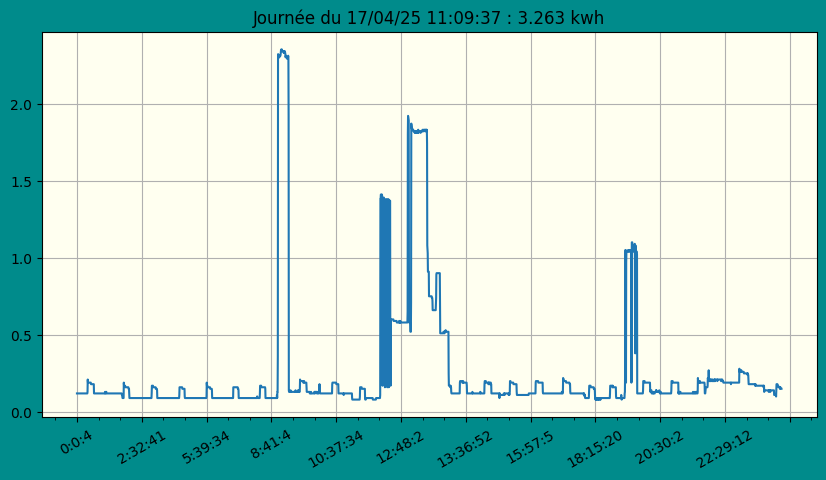

In [1208]:
show('17/04/25')

In [1209]:
end = time.time()
print(end - start)

34.70078659057617


### 1 kWh window in data of one day
#### df = conso_day

In [1210]:
df = conso_day
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
998734,36408,0.10,36.408,98.879367,26152809852,2025-06-11 00:00:18.053401,11/06/25
998735,34245,0.10,34.245,105.124836,26152844097,2025-06-11 00:00:52.298401,11/06/25
998736,34011,0.10,34.011,105.848108,26152878108,2025-06-11 00:01:26.309401,11/06/25
998737,35445,0.10,35.445,101.565806,26152913553,2025-06-11 00:02:01.754401,11/06/25
998738,35719,0.10,35.719,100.786696,26152949272,2025-06-11 00:02:37.473401,11/06/25
...,...,...,...,...,...,...,...
999995,2446,1.47,2.446,1471.790679,26192933744,2025-06-11 11:09:01.945401,11/06/25
999996,2449,1.47,2.449,1469.987750,26192936193,2025-06-11 11:09:04.394401,11/06/25
999997,2454,1.47,2.454,1466.992665,26192938647,2025-06-11 11:09:06.848401,11/06/25
999998,2447,1.47,2.447,1471.189211,26192941094,2025-06-11 11:09:09.295401,11/06/25


In [1211]:

def period(df=df, p=1):
    ''' 
    give the time of conso for a 1kWh window in a day
    p =  ordinal window ex: p=1 first kWh, p=2 second kWh ..
    df is the data from midnight, each entry is 1 watt
    as the length of df is the total conso in watt,
    we have len(df)/1000 = number of windows of 1 KWh since midnight
    the last window may not be 1000 watt long !
    '''
    if p==1:
        start = df.iloc[0].dates
    else:
        start = df.iloc[(p-1)*1000-1].dates
    if len(df)>p*1000:
        end = df.iloc[p*1000-1].dates
        conso = p*1000
    else:
        end = df.iloc[len(df)-1].dates
        conso = len(df) - (p-1)*1000
    period = end - start  # type timedelta
    hours = int(period / dt.timedelta(hours=1))
    mins = int(period / dt.timedelta(minutes=1)) - hours*60
    secs = int(period / dt.timedelta(seconds=1)) - hours*3600 - mins*60

    #df.iloc[1001:2000]['dates']#.tail(1)
    #print(period)
    print(f'{start}\t{end}\t{hours}h {mins}m {secs}s \t{conso}')


In [1212]:
df = conso_day
len(df)

1266

In [1213]:
period()  # first kWh
if len(df)>1000:
    period(p=2) # second period

2025-06-11 00:00:18.053401	2025-06-11 09:21:35.075401	9h 21m 17s 	1000
2025-06-11 09:21:35.075401	2025-06-11 11:09:11.741401	1h 47m 36s 	266


In [1214]:
# mean of all instant conso
total_mean = conso_data[['kWh']].mean()
total_mean

kWh    0.306192
dtype: float64

In [1215]:
end = time.time()
print(end - start)

35.08379626274109


## mean for data grouped by days

In [1216]:
mean=(grouped.count()/1000).mean()
mean

kWh    3.289474
dtype: float64

In [1217]:
last=df_grp.iloc[-1]['kWh']
last

np.float64(1.266)

# conso by date


In [1218]:
# select day
day = today

#day = '16/08/24'
day

'11/06/25'

In [1219]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
998734,36408,0.10,36.408,98.879367,26152809852,2025-06-11 00:00:18.053401,11/06/25
998735,34245,0.10,34.245,105.124836,26152844097,2025-06-11 00:00:52.298401,11/06/25
998736,34011,0.10,34.011,105.848108,26152878108,2025-06-11 00:01:26.309401,11/06/25
998737,35445,0.10,35.445,101.565806,26152913553,2025-06-11 00:02:01.754401,11/06/25
998738,35719,0.10,35.719,100.786696,26152949272,2025-06-11 00:02:37.473401,11/06/25
...,...,...,...,...,...,...,...
999995,2446,1.47,2.446,1471.790679,26192933744,2025-06-11 11:09:01.945401,11/06/25
999996,2449,1.47,2.449,1469.987750,26192936193,2025-06-11 11:09:04.394401,11/06/25
999997,2454,1.47,2.454,1466.992665,26192938647,2025-06-11 11:09:06.848401,11/06/25
999998,2447,1.47,2.447,1471.189211,26192941094,2025-06-11 11:09:09.295401,11/06/25


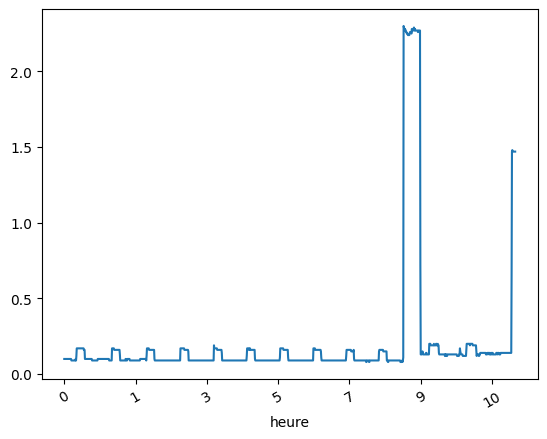

In [1220]:
conso_day=conso_data[conso_data['days']==day].copy()  # no more error
conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)) #+':'+str(x.minute) +':'+str(x.second))
#=[x.hour for x in conso_day['dates']]
df3= conso_day.set_index('heure')
df3.tail(2000)['kWh'].plot()
plt.xticks(rotation=30);
#conso_day['heure']


In [1221]:
end = time.time()
print(end - start)

35.801907539367676


### grouped by 'heure'

In [1222]:
conso_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1266 entries, 998734 to 999999
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   1266 non-null   int64         
 1   kWh        1266 non-null   float64       
 2   sec        1266 non-null   float64       
 3   Wh         1266 non-null   float64       
 4   cumul(ms)  1266 non-null   int64         
 5   dates      1266 non-null   datetime64[ns]
 6   days       1266 non-null   object        
 7   heure      1266 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 89.0+ KB


In [1223]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
998734,36408,0.10,36.408,98.879367,26152809852,2025-06-11 00:00:18.053401,11/06/25
998735,34245,0.10,34.245,105.124836,26152844097,2025-06-11 00:00:52.298401,11/06/25
998736,34011,0.10,34.011,105.848108,26152878108,2025-06-11 00:01:26.309401,11/06/25
998737,35445,0.10,35.445,101.565806,26152913553,2025-06-11 00:02:01.754401,11/06/25
998738,35719,0.10,35.719,100.786696,26152949272,2025-06-11 00:02:37.473401,11/06/25
...,...,...,...,...,...,...,...
999995,2446,1.47,2.446,1471.790679,26192933744,2025-06-11 11:09:01.945401,11/06/25
999996,2449,1.47,2.449,1469.987750,26192936193,2025-06-11 11:09:04.394401,11/06/25
999997,2454,1.47,2.454,1466.992665,26192938647,2025-06-11 11:09:06.848401,11/06/25
999998,2447,1.47,2.447,1471.189211,26192941094,2025-06-11 11:09:09.295401,11/06/25


In [1224]:
# group by hour, df  = data of a chosen day
df_byhour = df3[['days','kWh']].groupby('heure', sort=False)
df_byhour.groups

{'0': ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', ...], '1': ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '

In [1225]:
kwh_byhour = df_byhour['kWh']
kwh_byhour.count()

heure
0     108
1     105
2     103
3     101
4     102
5     107
6     100
7      98
8      98
9     170
10    142
11     32
Name: kWh, dtype: int64

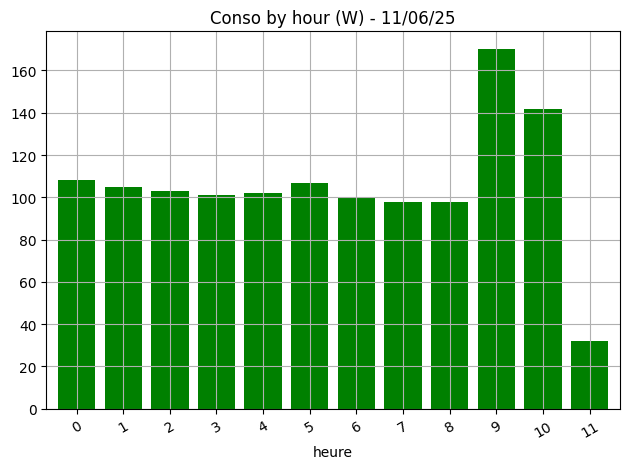

In [1226]:
kwh_byhour.count().plot(grid=True, kind='bar',color='green',width=.8)
plt.title(f'Conso by hour (W) - {day}')
plt.xticks(rotation=30);
plt.tight_layout()

In [1227]:
df_grp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 304 entries, 12/08/24 to 11/06/25
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     304 non-null    float64
dtypes: float64(1)
memory usage: 4.8+ KB


In [1228]:
# give the periods of 1 kwh in a day
period()

2025-06-11 00:00:18.053401	2025-06-11 09:21:35.075401	9h 21m 17s 	1000


In [1229]:

# premier kWh
if len(df)>1000:
    df.iloc[1000]['dates']
    df.iloc[0].dates, df.iloc[1000].dates
#df.dates.dt.time


In [1230]:

# save data
# df_grp.to_csv('df_grp.csv')
# df.to_csv('df.csv')
df_grp.to_csv('conso_day_from_20230821.csv')

#df.info()
#df_grp


In [1231]:
df_grp.mean()


kWh    3.289474
dtype: float64

In [1232]:
df_grp.head()


,kWh
days,
12/08/24,2.987
13/08/24,4.333
14/08/24,3.907
15/08/24,3.860
16/08/24,4.058


In [1233]:
df_grp.tail()


,kWh
days,
07/06/25,3.062
08/06/25,3.165
09/06/25,3.362
10/06/25,3.824
11/06/25,1.266


In [1234]:
end = time.time()
print(end - start)

37.21364879608154


# plot les 100 derniers jours


In [1235]:
# moyenne sur 100 jours
df_grp.tail(100).mean()


kWh    3.27984
dtype: float64

Text(0.5, 1.0, 'Conso (kWh) last 100 days')

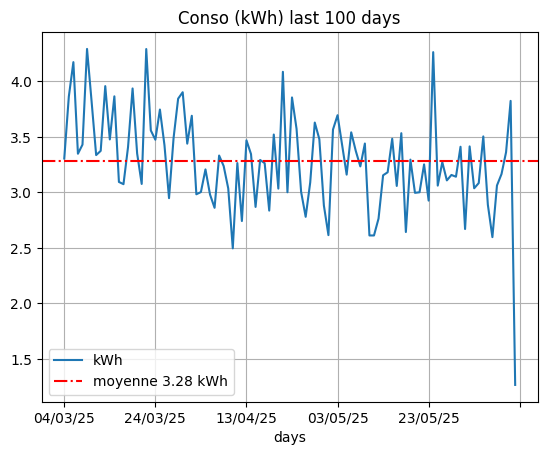

In [1236]:
# plot last 100 days
df_100 = df_grp.tail(100)
df_100.plot()
plt.axhline(y=np.nanmean(df_100),c='red', ls='-.',label=f'moyenne {np.nanmean(df_100):.2f} kWh')
plt.grid()
plt.legend()
plt.title('Conso (kWh) last 100 days')


In [1237]:
# max min during last 100 days
df_100.describe().loc[['min','max']]


,kWh
min,1.266
max,4.292


In [1238]:
end = time.time()
print(end - start)

37.84920406341553


In [1239]:
df_grp[-31:-1].index[0],df_grp[-31:-1].index[-5]

('12/05/25', '06/06/25')

In [1240]:
moyenne = df_grp.iloc[-31:-1].mean()
moyenne

kWh    3.1769
dtype: float64

Text(0.5, 1.0, 'Last month conso by day')

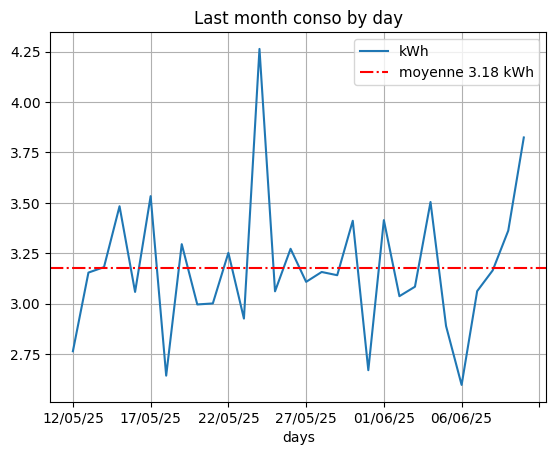

In [1241]:
# plot last monthh
df_grp.iloc[-31:-1].plot()
plt.axhline(y=np.nanmean(df_grp.iloc[-31:-1]),c='red', ls='-.',label=f'moyenne {np.nanmean(df_grp.iloc[-31:-1]):.2f} kWh')  
plt.legend()
plt.grid()
plt.title('Last month conso by day')


In [1242]:
month = df_grp.iloc[-31:-1]['kWh']
print('Max :',month.idxmax(), max(month))
print('Min :',month.idxmin(), min(month))

Max : 24/05/25 4.263
Min : 06/06/25 2.597


# Temps de conso par tranche de 1 kWh

In [1243]:
def show_tranches():    # temps de conso par tranches de 1kwh
    tranches = len(df)//1000
    print(tranches+1)
    for p in range(1,tranches+2):  # les 5 tranches de kWh consommés
        if len(df)>(p-1)*1000:
            period(p=p)

show_tranches()


2
2025-06-11 00:00:18.053401	2025-06-11 09:21:35.075401	9h 21m 17s 	1000
2025-06-11 09:21:35.075401	2025-06-11 11:09:11.741401	1h 47m 36s 	266


In [1244]:
# conso temps réel
here = now.strftime('%H:%M:%S')
conso_jour=len(df['kWh'])
here, len(df)/1000, conso_jour


('11:09:37', 1.266, 1266)

In [1245]:
#add hours column for a chosen day
conso_hours = conso_day.copy()
conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
conso_hours.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1266 entries, 998734 to 999999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   1266 non-null   int64         
 1   kWh        1266 non-null   float64       
 2   sec        1266 non-null   float64       
 3   Wh         1266 non-null   float64       
 4   cumul(ms)  1266 non-null   int64         
 5   dates      1266 non-null   datetime64[ns]
 6   days       1266 non-null   object        
 7   heure      1266 non-null   object        
 8   hours      1266 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 98.9+ KB


In [1246]:
conso_hours['heure'], conso_hours['hours']

(998734     0
 998735     0
 998736     0
 998737     0
 998738     0
           ..
 999995    11
 999996    11
 999997    11
 999998    11
 999999    11
 Name: heure, Length: 1266, dtype: object,
 998734    00
 998735    00
 998736    00
 998737    00
 998738    00
           ..
 999995    11
 999996    11
 999997    11
 999998    11
 999999    11
 Name: hours, Length: 1266, dtype: object)

In [1247]:
end = time.time()
print(end - start)

39.21108794212341


# select number of days to display


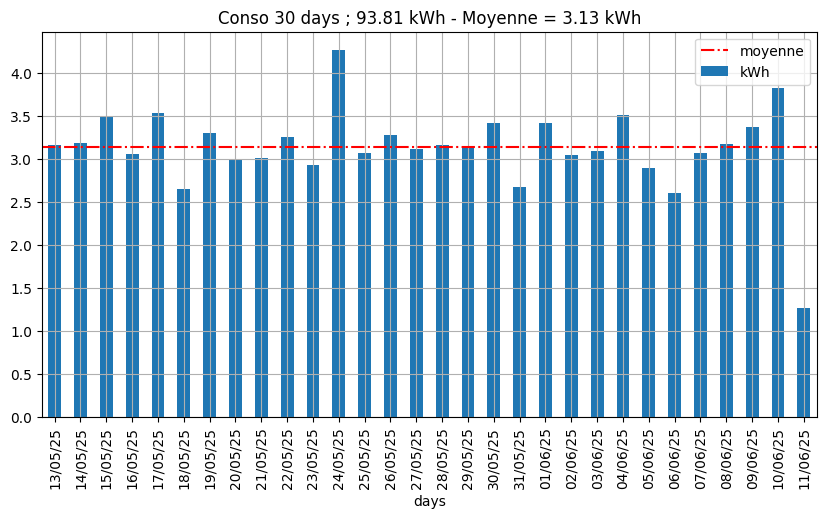

In [1248]:
span = 30
conso_mois = round(df_grp.tail(span)['kWh'].sum(),2)

# Plot the figure without labels
moy = round(np.nanmean(df_grp.tail(span)),2)
#conso_mois = sum(df_grp.tail(span)['kWh'])
df_grp.tail(span).plot.bar(grid=True, figsize=(10, 5), layout='tight')
 
plt.title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
plt.xticks(rotation=90);


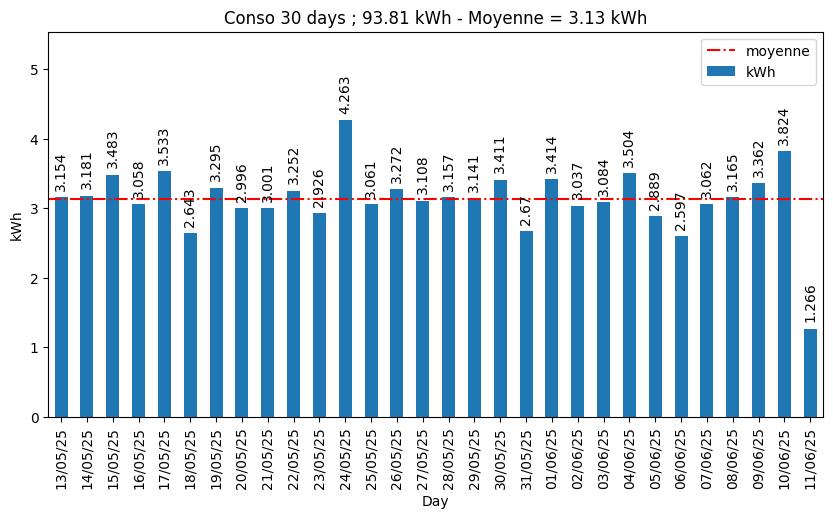

In [1249]:
# Plot the figure with labels.
x_labels = list(df_grp.tail(span)['kWh'])
#x_labels
#fig, ax = plt.subplots(figsize=(2, 2), facecolor='lightskyblue',layout='constrained')
ax = df_grp.tail(span).plot(kind="bar", figsize=(10, 5), layout='tight')
#ax.set_title(f"Conso by {span} days")
ax.set_title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
ax.set_xlabel("Day")
ax.set_ylabel("kWh")
ax.set_ymargin(0.3)
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
#ax.set_xticklabels(x_labels)
#fig.tight_layout()

rects = ax.patches

# Make some labels.
labels = [x_labels[i] for i in range(len(x_labels))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    #print(height)
    ax.text(
        rect.get_x() + rect.get_width() / 2, height+.1, label, ha="center", va="bottom", rotation=90
    )

#plt.show()

In [1250]:
y_labels = df_grp.tail(span)['kWh']
y_labels

days
13/05/25    3.154
14/05/25    3.181
15/05/25    3.483
16/05/25    3.058
17/05/25    3.533
18/05/25    2.643
19/05/25    3.295
20/05/25    2.996
21/05/25    3.001
22/05/25    3.252
23/05/25    2.926
24/05/25    4.263
25/05/25    3.061
26/05/25    3.272
27/05/25    3.108
28/05/25    3.157
29/05/25    3.141
30/05/25    3.411
31/05/25    2.670
01/06/25    3.414
02/06/25    3.037
03/06/25    3.084
04/06/25    3.504
05/06/25    2.889
06/06/25    2.597
07/06/25    3.062
08/06/25    3.165
09/06/25    3.362
10/06/25    3.824
11/06/25    1.266
Name: kWh, dtype: float64

In [1251]:
x_labels=df_grp.tail(span).index
x_labels

Index(['13/05/25', '14/05/25', '15/05/25', '16/05/25', '17/05/25', '18/05/25',
       '19/05/25', '20/05/25', '21/05/25', '22/05/25', '23/05/25', '24/05/25',
       '25/05/25', '26/05/25', '27/05/25', '28/05/25', '29/05/25', '30/05/25',
       '31/05/25', '01/06/25', '02/06/25', '03/06/25', '04/06/25', '05/06/25',
       '06/06/25', '07/06/25', '08/06/25', '09/06/25', '10/06/25', '11/06/25'],
      dtype='object', name='days')

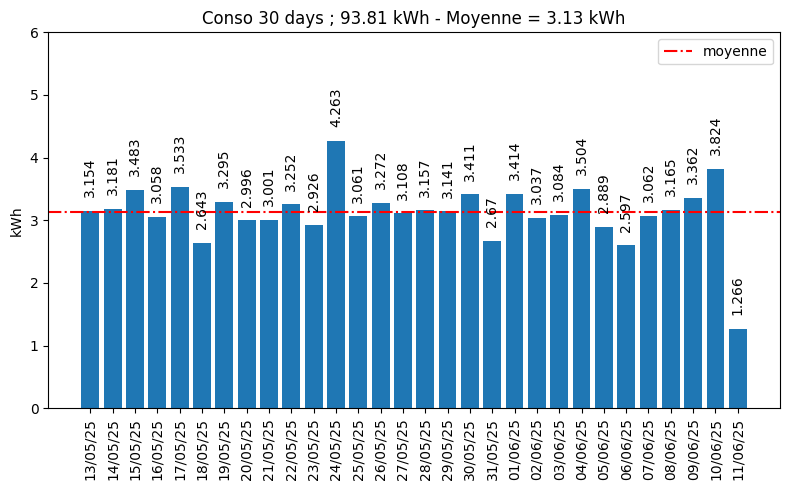

In [1252]:
# Plot the figure with labels
# using bar_label
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html#sphx-glr-gallery-lines-bars-and-markers-bar-label-demo-py
fig, ax = plt.subplots(figsize=(8, 5), layout='tight')
bar_container = ax.bar(x_labels, y_labels)
#ax.set_xticks(x_labels, rotation=45)
#ax.set_title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
ax.bar_label(bar_container, rotation=90, padding=10) #, fmt='{:,.0f}')
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
ax.set(ylabel='kWh', title=f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh', ylim=(0, 6))
plt.xticks(rotation=90);


In [1253]:
end = time.time()
print(end - start)

44.2552444934845


In [1254]:
# figure manager

current=plt.get_current_fig_manager()
current.set_window_title('Conso by day')
#help(current.canvas)
#,facecolor='darkcyan')
#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
#plt.style.use('dark_background')


<Figure size 640x480 with 0 Axes>

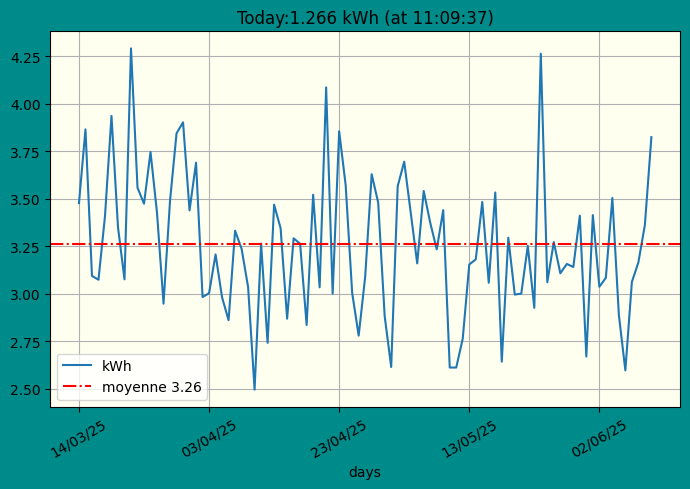

In [1255]:
# 3 last months
scan = 90
# pandas plot the day consos in the group
fig, ax = plt.subplots(facecolor='darkcyan', figsize=(7, 5), layout='tight')  # as argument
#or fig.patch.set_facecolor('darkcyan') # This changes the grey to white
ax.set_facecolor("ivory")

moy = round(np.nanmean(df_grp.iloc[-scan:-1]),2)
df_grp.iloc[-scan:-1].plot(grid=True,ax=ax, y=["kWh"])   #df.plot(x="Name", y=["Age", "Height(in cm)"], kind="bar", ax=ax)
plt.title(f'Today:{last} kWh (at {here})')
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.xticks(rotation=30);  # https://ipython.readthedocs.io/en/stable/interactive/tips.html


Text(0.5, 1.0, 'Variations journalières')

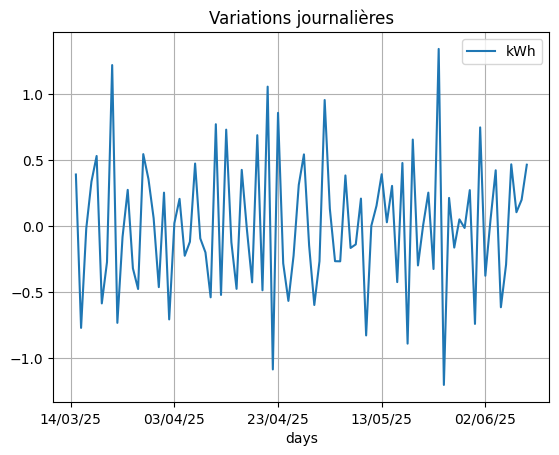

In [1256]:
# variations journalières sur 60 jours
df_grp.iloc[-scan:-1].diff().plot(grid=True)
plt.title('Variations journalières')

In [1257]:
end = time.time()
print(end - start)

48.969422578811646


# Data from 21/08/23

In [1258]:
# add hours column for conso_data (from 21/08/2023)
conso_days = conso_data.copy()
conso_days['hours']= conso_days['dates'].dt.strftime('%H')

conso_days['months']= conso_days['dates'].dt.strftime('%Y-%m')
conso_days['day']= conso_days['dates'].dt.strftime('%d')
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,23895,0.15,23.895,150.659134,23895,2024-08-12 07:20:32.096401,12/08/24,07,2024-08,12
1,24766,0.14,24.766,145.360575,48661,2024-08-12 07:20:56.862401,12/08/24,07,2024-08,12
2,24825,0.14,24.825,145.015106,73486,2024-08-12 07:21:21.687401,12/08/24,07,2024-08,12
3,25008,0.14,25.008,143.953935,98494,2024-08-12 07:21:46.695401,12/08/24,07,2024-08,12
4,25158,0.14,25.158,143.095636,123652,2024-08-12 07:22:11.853401,12/08/24,07,2024-08,12
...,...,...,...,...,...,...,...,...,...,...
999995,2446,1.47,2.446,1471.790679,26192933744,2025-06-11 11:09:01.945401,11/06/25,11,2025-06,11
999996,2449,1.47,2.449,1469.987750,26192936193,2025-06-11 11:09:04.394401,11/06/25,11,2025-06,11
999997,2454,1.47,2.454,1466.992665,26192938647,2025-06-11 11:09:06.848401,11/06/25,11,2025-06,11
999998,2447,1.47,2.447,1471.189211,26192941094,2025-06-11 11:09:09.295401,11/06/25,11,2025-06,11


In [1259]:
end = time.time()
print(end - start)

89.21202945709229


In [1260]:
conso_grouped_by_month = conso_days[['day','hours','months','kWh']].groupby('months', sort=False)

conso_grouped_by_month.groups.keys()

dict_keys(['2024-08', '2024-09', '2024-10', '2024-11', '2024-12', '2025-01', '2025-02', '2025-03', '2025-04', '2025-05', '2025-06'])

# define month to show

Text(0.5, 1.0, 'Conso by day (W) (2025-04)')

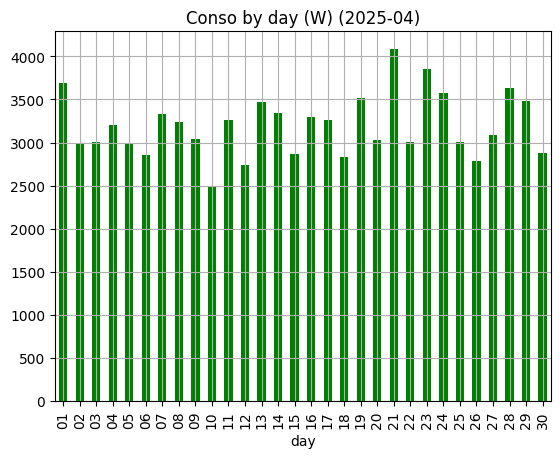

In [1261]:
m = '2025-04'
month=conso_grouped_by_month.get_group(m)
conso_grouped_by_month_day = month.groupby(['day'], sort=False)
conso_grouped_by_month_day['kWh'].count().plot(grid=True,kind='bar',color='green',width=.5)
plt.title(f'Conso by day (W) ({m})')

In [1262]:
c=conso_grouped_by_month_day['hours'].count()
c.mean()


np.float64(3194.6666666666665)

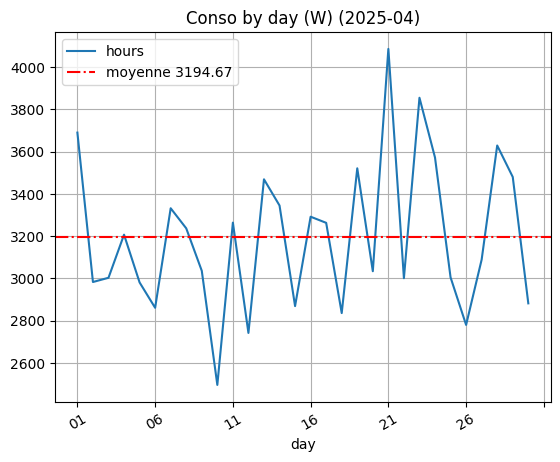

In [1263]:
conso_grouped_by_month_day['hours'].count().plot(grid=True)#, kind='bar', color='green', width=.8)
moy = round(c.mean(),2)
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.title(f'Conso by day (W) ({month.iloc[0]['months']})')
plt.xticks(rotation=30);


In [1264]:
conso_grouped_by_month_and_day = conso_days[['day','hours','months','kWh']].groupby(['months','day'], sort=False)

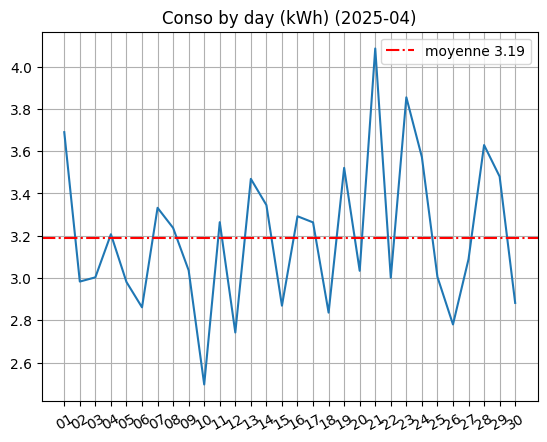

In [1265]:
plt.plot(conso_grouped_by_month_day['kWh'].count()/1000)
plt.grid()
moy = round(c.mean()/1000,2)
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.title(f'Conso by day (kWh) ({month.iloc[0]['months']})')
plt.xticks(rotation=30);

In [1266]:
# Example: Get data for January 2025 at hour '00'
#group = conso_grouped_by_month_and_day.get_group('2025-01')
#group

In [1267]:
# group.plot(grid=True, kind='bar', color='green', width=.8)
# plt.title('Conso by hour (W) - 2025-01')
# plt.xticks(rotation=30);


In [1268]:
# conso total par mois
conso_grouped_by_month.count()


,day,hours,kWh
months,,,
2024-08,76803,76803,76803
2024-09,69843,69843,69843
2024-10,73436,73436,73436
2024-11,108513,108513,108513
2024-12,113700,113700,113700
2025-01,113745,113745,113745
2025-02,104439,104439,104439
2025-03,111831,111831,111831
2025-04,95840,95840,95840


In [1269]:
# example groupby with apply
df2 = pd.DataFrame({'Animal': ['Falcon', 'Falcon',
                              'Parrot', 'Parrot'],
                   'Max Speed': [380., 370., 24., 26.]})
df2.groupby("Animal", group_keys=True)[['Max Speed']].apply(lambda x: x)
      

Max Speed
Animal             
Falcon 0      380.0
       1      370.0
Parrot 2       24.0
       3       26.0

In [1270]:
# import pandas as pd
# df = pd.read_csv(r'../csv/only-bh-extreme-events-satellite.csv'
#                   ,index_col=[0,1,2,3,4]
#                   ,header=[0,1,2,3]
#                   ,skipinitialspace=True
#                   #,tupleize_cols=True
#                 ) 

# df.columns = pd.MultiIndex.from_tuples(df.columns)
# df.index.names
# index=df.columns.levels[0]
# index
# df_des = pd.DataFrame(
#                             index=df.columns.levels[0],
#                             columns=['count','mean','std','min','25','50','75','max']
#                          )
# df_des

In [1271]:
groupallbyday = conso_days[['days','hours','kWh']].groupby(['days'], sort=False)
groupallbyday[['kWh']].count()  #.apply(lambda x: x))

,kWh
days,
12/08/24,2987
13/08/24,4333
14/08/24,3907
15/08/24,3860
16/08/24,4058
...,...
07/06/25,3062
08/06/25,3165
09/06/25,3362


In [1272]:
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,23895,0.15,23.895,150.659134,23895,2024-08-12 07:20:32.096401,12/08/24,07,2024-08,12
1,24766,0.14,24.766,145.360575,48661,2024-08-12 07:20:56.862401,12/08/24,07,2024-08,12
2,24825,0.14,24.825,145.015106,73486,2024-08-12 07:21:21.687401,12/08/24,07,2024-08,12
3,25008,0.14,25.008,143.953935,98494,2024-08-12 07:21:46.695401,12/08/24,07,2024-08,12
4,25158,0.14,25.158,143.095636,123652,2024-08-12 07:22:11.853401,12/08/24,07,2024-08,12
...,...,...,...,...,...,...,...,...,...,...
999995,2446,1.47,2.446,1471.790679,26192933744,2025-06-11 11:09:01.945401,11/06/25,11,2025-06,11
999996,2449,1.47,2.449,1469.987750,26192936193,2025-06-11 11:09:04.394401,11/06/25,11,2025-06,11
999997,2454,1.47,2.454,1466.992665,26192938647,2025-06-11 11:09:06.848401,11/06/25,11,2025-06,11
999998,2447,1.47,2.447,1471.189211,26192941094,2025-06-11 11:09:09.295401,11/06/25,11,2025-06,11


In [1273]:

# group all by day for all conso_days
groupallbydayhours = conso_days[['days','hours','kWh']].groupby(['days','hours'], sort=False)
# use apply to show the group
groupallbydayhours[['days','hours','kWh']].apply(lambda x: x)


days hours   kWh
days     hours                             
12/08/24 07    0       12/08/24    07  0.15
               1       12/08/24    07  0.14
               2       12/08/24    07  0.14
               3       12/08/24    07  0.14
               4       12/08/24    07  0.14
...                         ...   ...   ...
11/06/25 11    999995  11/06/25    11  1.47
               999996  11/06/25    11  1.47
               999997  11/06/25    11  1.47
               999998  11/06/25    11  1.47
               999999  11/06/25    11  1.47

[1000000 rows x 3 columns]

In [1274]:
groupallbyday.indices.keys()

dict_keys(['12/08/24', '13/08/24', '14/08/24', '15/08/24', '16/08/24', '17/08/24', '18/08/24', '19/08/24', '20/08/24', '21/08/24', '22/08/24', '23/08/24', '24/08/24', '25/08/24', '26/08/24', '27/08/24', '28/08/24', '29/08/24', '30/08/24', '31/08/24', '01/09/24', '02/09/24', '03/09/24', '04/09/24', '05/09/24', '06/09/24', '07/09/24', '08/09/24', '09/09/24', '10/09/24', '11/09/24', '12/09/24', '13/09/24', '14/09/24', '15/09/24', '16/09/24', '17/09/24', '18/09/24', '19/09/24', '20/09/24', '21/09/24', '22/09/24', '23/09/24', '24/09/24', '25/09/24', '26/09/24', '27/09/24', '28/09/24', '29/09/24', '30/09/24', '01/10/24', '02/10/24', '03/10/24', '04/10/24', '05/10/24', '06/10/24', '07/10/24', '08/10/24', '09/10/24', '10/10/24', '11/10/24', '12/10/24', '13/10/24', '14/10/24', '15/10/24', '16/10/24', '17/10/24', '18/10/24', '19/10/24', '20/10/24', '21/10/24', '22/10/24', '23/10/24', '24/10/24', '25/10/24', '26/10/24', '27/10/24', '28/10/24', '29/10/24', '30/10/24', '31/10/24', '01/11/24', '02/1

In [1275]:
groupallbydayhours.indices.keys()

dict_keys([('12/08/24', '07'), ('12/08/24', '08'), ('12/08/24', '09'), ('12/08/24', '10'), ('12/08/24', '11'), ('12/08/24', '12'), ('12/08/24', '13'), ('12/08/24', '14'), ('12/08/24', '15'), ('12/08/24', '16'), ('12/08/24', '17'), ('12/08/24', '18'), ('12/08/24', '19'), ('12/08/24', '20'), ('12/08/24', '21'), ('12/08/24', '22'), ('12/08/24', '23'), ('13/08/24', '07'), ('13/08/24', '08'), ('13/08/24', '09'), ('13/08/24', '10'), ('13/08/24', '11'), ('13/08/24', '12'), ('13/08/24', '13'), ('13/08/24', '14'), ('13/08/24', '15'), ('13/08/24', '16'), ('13/08/24', '17'), ('13/08/24', '18'), ('13/08/24', '19'), ('13/08/24', '20'), ('13/08/24', '21'), ('13/08/24', '22'), ('13/08/24', '23'), ('13/08/24', '00'), ('13/08/24', '01'), ('13/08/24', '02'), ('13/08/24', '03'), ('13/08/24', '04'), ('13/08/24', '05'), ('13/08/24', '06'), ('14/08/24', '07'), ('14/08/24', '08'), ('14/08/24', '09'), ('14/08/24', '10'), ('14/08/24', '11'), ('14/08/24', '12'), ('14/08/24', '13'), ('14/08/24', '14'), ('14/08/2

In [1276]:
grp_by_day = groupallbyday.count()
grp_by_day

,hours,kWh
days,,
12/08/24,2987,2987
13/08/24,4333,4333
14/08/24,3907,3907
15/08/24,3860,3860
16/08/24,4058,4058
...,...,...
07/06/25,3062,3062
08/06/25,3165,3165
09/06/25,3362,3362


In [1277]:
grp_by_day['kWh'].cumsum()

days
12/08/24       2987
13/08/24       7320
14/08/24      11227
15/08/24      15087
16/08/24      19145
             ...   
07/06/25     988383
08/06/25     991548
09/06/25     994910
10/06/25     998734
11/06/25    1000000
Name: kWh, Length: 304, dtype: int64

In [1278]:
grp_by_dayhours = groupallbydayhours.count()
grp_by_dayhours

kWh
days     hours     
12/08/24 07      78
         08     129
         09     122
         10     120
         11     180
...             ...
11/06/25 07      98
         08      98
         09     170
         10     142
         11      32

[7277 rows x 1 columns]

In [1279]:
grp_by_dayhours['kWh'].cumsum()

days      hours
12/08/24  07            78
          08           207
          09           329
          10           449
          11           629
                    ...   
11/06/25  07        999558
          08        999656
          09        999826
          10        999968
          11       1000000
Name: kWh, Length: 7277, dtype: int64

In [1280]:
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(level=0)['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(level=0)['kWh'].diff()
# or
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(['days'])['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(['days'])['kWh'].diff()
grp_by_dayhours

kWh  cumsum   diff
days     hours                    
12/08/24 07      78      78    NaN
         08     129     207   51.0
         09     122     329   -7.0
         10     120     449   -2.0
         11     180     629   60.0
...             ...     ...    ...
11/06/25 07      98     824   -2.0
         08      98     922    0.0
         09     170    1092   72.0
         10     142    1234  -28.0
         11      32    1266 -110.0

[7277 rows x 3 columns]

In [1281]:
today, grp_by_dayhours.loc[today]

('11/06/25',
        kWh  cumsum   diff
 hours                    
 00     108     108    NaN
 01     105     213   -3.0
 02     103     316   -2.0
 03     101     417   -2.0
 04     102     519    1.0
 05     107     626    5.0
 06     100     726   -7.0
 07      98     824   -2.0
 08      98     922    0.0
 09     170    1092   72.0
 10     142    1234  -28.0
 11      32    1266 -110.0)

Text(0.5, 1.0, 'Cumul journalier')

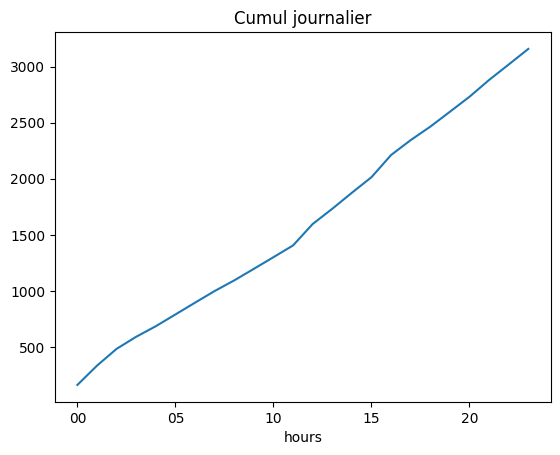

In [1282]:
# progression sans surprise
grp_by_dayhours.loc['05/11/24']['cumsum'].plot()
plt.title('Cumul journalier')

Text(0.5, 1.0, 'Variation horaire')

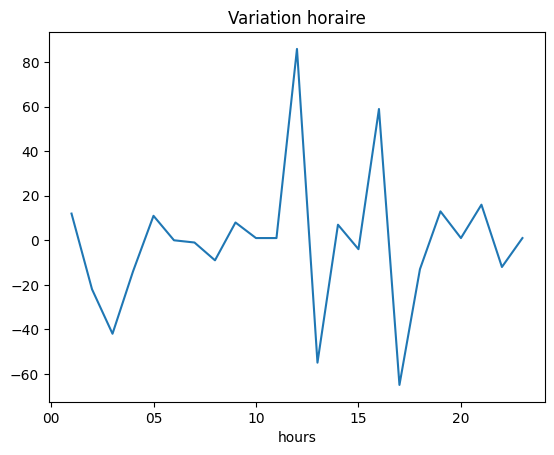

In [1283]:
# plus parlant
grp_by_dayhours.loc['05/11/24']['diff'].plot()
plt.title(r'Variation horaire')

In [1284]:
# count number of days since 21/08/2023
# https://stackoverflow.com/questions/45972388/count-my-multi-index-length-in-a-dataframe-pandas
n = len(grp_by_dayhours.index.levels[0].unique())
# or
n = len(grp_by_dayhours.index.levels[0])
# or
n = grp_by_dayhours.index.levshape[0]  # levshape -> (371,24)
n

304

In [1285]:
df_grp.tail(n)['kWh'].describe()


count    304.000000
mean       3.289474
std        0.731019
min        1.266000
25%        3.060250
50%        3.419500
75%        3.759750
max        4.863000
Name: kWh, dtype: float64

In [1286]:
maxday = df_grp.tail(n)['kWh'].idxmax()

In [1287]:
n, np.nanmean(df_grp.tail(n))

(304, np.float64(3.289473684210526))

Text(0.5, 1.0, '304 days')

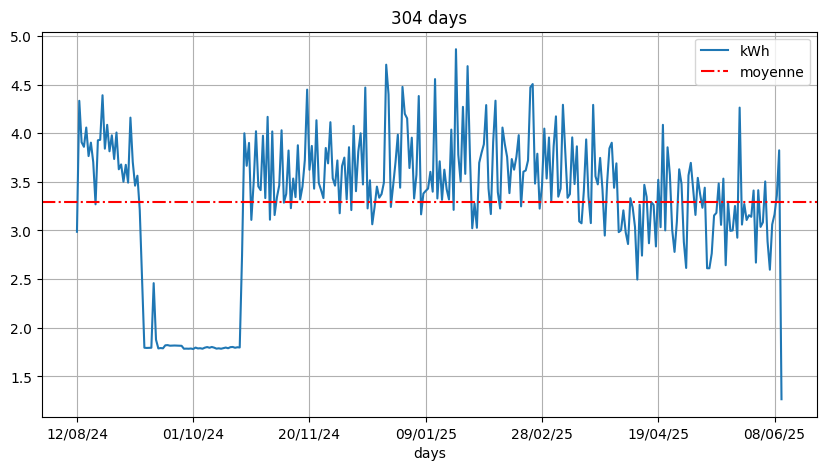

In [1288]:
# show conso in span 
span = n
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.legend()
plt.title(f'{span} days')

Text(0.5, 1.0, '100 days')

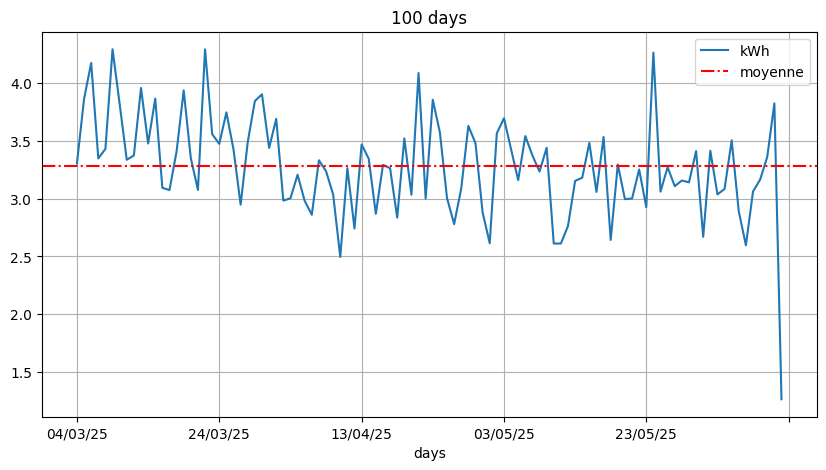

In [1289]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.legend()
plt.title(f'{span} days')

In [1290]:
np.nanmean(df_grp.tail(span))

np.float64(3.2798400000000005)

In [1291]:
df_grp['kWh']

days
12/08/24    2.987
13/08/24    4.333
14/08/24    3.907
15/08/24    3.860
16/08/24    4.058
            ...  
07/06/25    3.062
08/06/25    3.165
09/06/25    3.362
10/06/25    3.824
11/06/25    1.266
Name: kWh, Length: 304, dtype: float64

In [1292]:
df_grp.describe()

,kWh
count,304.000000
mean,3.289474
std,0.731019
min,1.266000
25%,3.060250
50%,3.419500
75%,3.759750
max,4.863000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

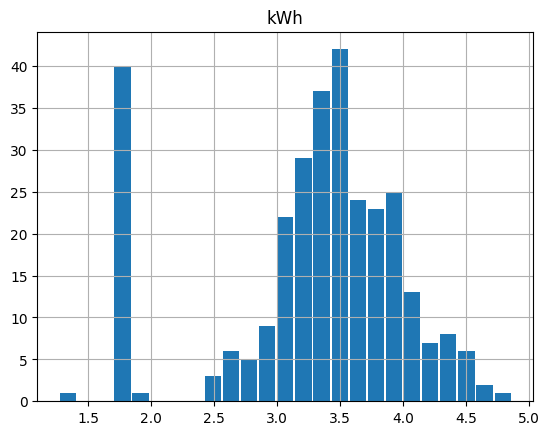

In [1293]:
# répartition des consos de 1 à 5 kWh par jour
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
# histtype{'bar', 'barstacked', 'step', 'stepfilled'}, default: 'bar'
df_grp.hist(bins=25, density=False, histtype='bar',rwidth=0.9, align='mid')

In [1294]:
df_grp.tail(span)['kWh']

days
04/03/25    3.305
05/03/25    3.863
06/03/25    4.173
07/03/25    3.348
08/03/25    3.430
            ...  
07/06/25    3.062
08/06/25    3.165
09/06/25    3.362
10/06/25    3.824
11/06/25    1.266
Name: kWh, Length: 100, dtype: float64

# Conso par heure

In [1295]:
day

'11/06/25'

In [1296]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff
hours,,,
00,108,108,NaN
01,105,213,-3.0
02,103,316,-2.0
03,101,417,-2.0
04,102,519,1.0
05,107,626,5.0
06,100,726,-7.0
07,98,824,-2.0
08,98,922,0.0


In [1297]:
# select a day to plot
day = '02/07/24'
day = today
len(grp_by_dayhours.loc[day])


12

In [1298]:
l = range(1,len(grp_by_dayhours.loc[day])+1)
l

range(1, 13)

In [1299]:
grp_by_dayhours.loc[day,'days'] = l #ist(1,len(grp_by_day.loc[day])+1)

In [1300]:
grp_by_dayhours.loc[day,'days'].values

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])

In [1301]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
Name: days, dtype: float64

In [1302]:
### ????????????????????????
grp_by_dayhours.loc[day,'days'] = grp_by_dayhours.loc[day,'days'].values.astype('int64')

In [1303]:
grp_by_dayhours.loc[day].info()

<class 'pandas.core.frame.DataFrame'>
Index: 12 entries, 00 to 11
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     12 non-null     int64  
 1   cumsum  12 non-null     int64  
 2   diff    11 non-null     float64
 3   days    12 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 480.0+ bytes


In [1304]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
Name: days, dtype: float64

In [1305]:
day

'11/06/25'

In [1306]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff,days
hours,,,,
00,108,108,NaN,1.0
01,105,213,-3.0,2.0
02,103,316,-2.0,3.0
03,101,417,-2.0,4.0
04,102,519,1.0,5.0
05,107,626,5.0,6.0
06,100,726,-7.0,7.0
07,98,824,-2.0,8.0
08,98,922,0.0,9.0


In [1307]:
kwh = grp_by_dayhours.loc[day][['kWh']]/1000
np.sum(kwh)[0]


c:\Users\jeand\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\jeand\AppData\Local\Temp\ipykernel_17636\2885532441.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.sum(kwh)[0]


np.float64(1.266)

In [1308]:
grp_by_dayhours

kWh  cumsum   diff  days
days     hours                          
12/08/24 07      78      78    NaN   NaN
         08     129     207   51.0   NaN
         09     122     329   -7.0   NaN
         10     120     449   -2.0   NaN
         11     180     629   60.0   NaN
...             ...     ...    ...   ...
11/06/25 07      98     824   -2.0   8.0
         08      98     922    0.0   9.0
         09     170    1092   72.0  10.0
         10     142    1234  -28.0  11.0
         11      32    1266 -110.0  12.0

[7277 rows x 4 columns]

c:\Users\jeand\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Text(0.5, 1.0, '11/06/25: kWh    1.266\ndtype: float64')

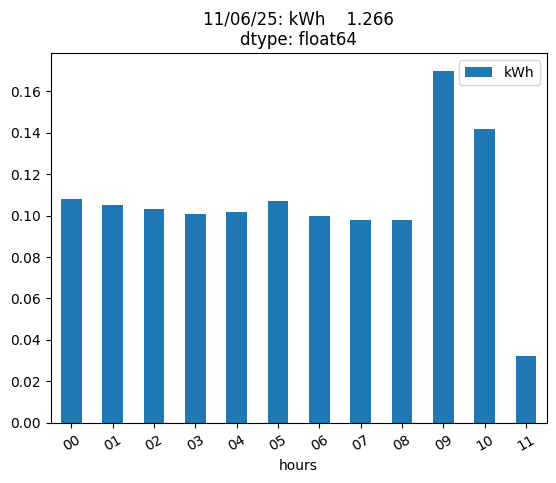

In [1309]:
kwh.plot.bar(label='watt')
plt.legend()
plt.xticks(rotation=30)
plt.title(f'{day}: {np.sum(kwh)}')

In [1310]:
grp_by_dayhours.loc[day].index

Index(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11'], dtype='object', name='hours')

# Conso du jour


In [1311]:
grp_by_dayhours.count()

kWh       7277
cumsum    7277
diff      6973
days        12
dtype: int64

'22/01/25'

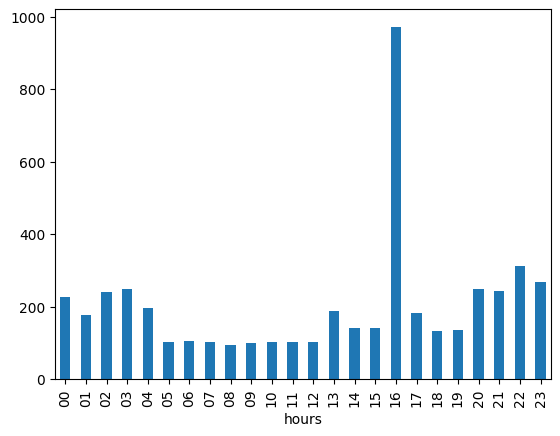

In [1312]:
#day = '09/09/24'
day = maxday
#day = today
grp_by_dayhours.loc[day].kWh.plot(kind='bar')
maxday

In [1313]:
def conso_by_hour(day):
    global data
    # conso by hour
    #data = groupedbyhour.count().kWh
    data = grp_by_dayhours.loc[day].kWh

    # len(groupedbyhour)
    x = np.arange(1,len(data)+1)
    ymax = max(data)+5
    #groupedbyhour.count().plot(grid=True,xticks=x)
    fig, ax = plt.subplots(figsize=(8, 5), facecolor='darkcyan')

    plt.bar(x,data)
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) {day} - Total {sum(data)}')
    plt.xlim(0,len(x)+1)
    #plt.xticks(rotation=30);
    #plt.ylim(0,ymax)

    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in data]
    fontfamily = {'calibri', 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 3, label, ha="center", va="bottom",
            fontfamily=fontfamily, fontsize=10, fontweight='bold', color='red'
        )


# 100 days

Total= 327.984 , Moyenne= 3.2798400000000005


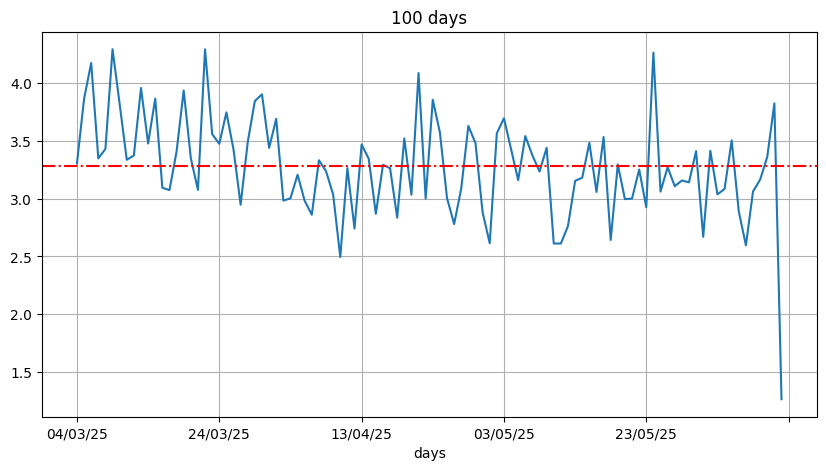

In [1314]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.title(f'{span} days')

print('Total=',sum(df_grp.tail(span)['kWh']),', Moyenne=',np.nanmean(df_grp.tail(span)))

In [1315]:
from datetime import datetime

# Get the current time
current_time = datetime.now()

# Convert the time to minutes in a day
minutes_in_day = current_time.hour * 60 + current_time.minute
print(f"Current time: {current_time.strftime('%H:%M:%S')}, Minutes in day: {minutes_in_day}")

Current time: 11:10:49, Minutes in day: 670


In [1316]:
def convert_to_min_sec(seconds):
    """
    Convert a float value in seconds to minutes and seconds.
    """
    minutes, sec = divmod(seconds, 60)
    return f'{int(minutes)}:{round(sec, 2)}'


In [1317]:
#import timeit
#start = timeit.timeit()
#print("hello")
end = time.time()
print(convert_to_min_sec(end - start))

1:43.55


In [1318]:
end - start

103.55408978462219

In [1319]:
#df = conso_day
show_tranches()

2
2025-06-11 00:00:18.053401	2025-06-11 09:21:35.075401	9h 21m 17s 	1000
2025-06-11 09:21:35.075401	2025-06-11 11:09:11.741401	1h 47m 36s 	266


In [1320]:
df_grp.tail(7)['kWh']

days
05/06/25    2.889
06/06/25    2.597
07/06/25    3.062
08/06/25    3.165
09/06/25    3.362
10/06/25    3.824
11/06/25    1.266
Name: kWh, dtype: float64

<Axes: xlabel='days'>

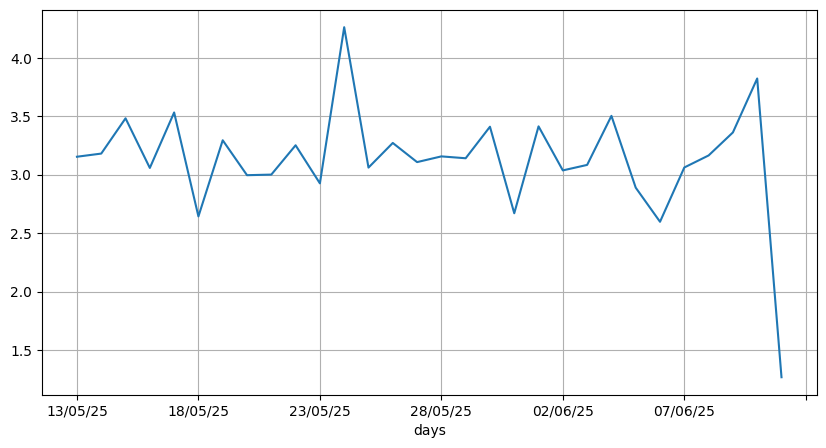

In [1321]:
df_grp.tail(30)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)

# Today

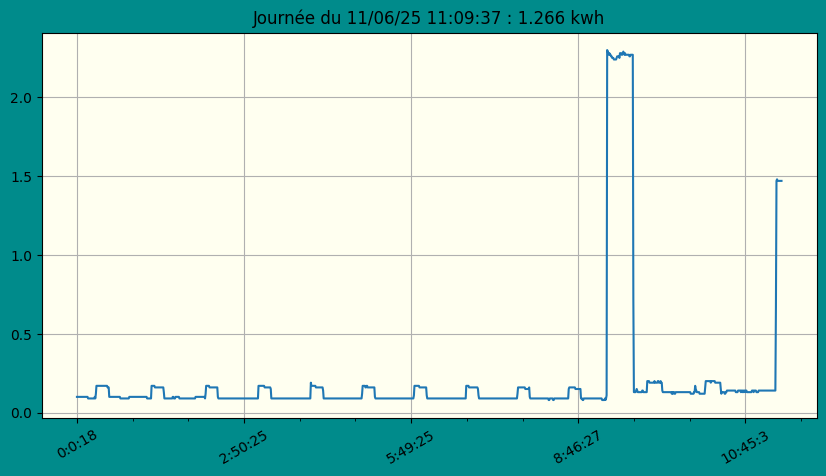

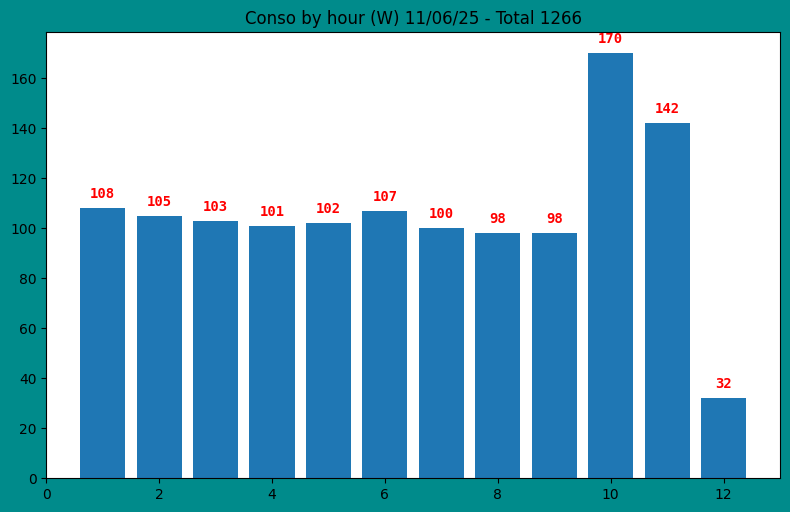

In [1322]:
show(today,bgcolor='ivory')
conso_by_hour(today)

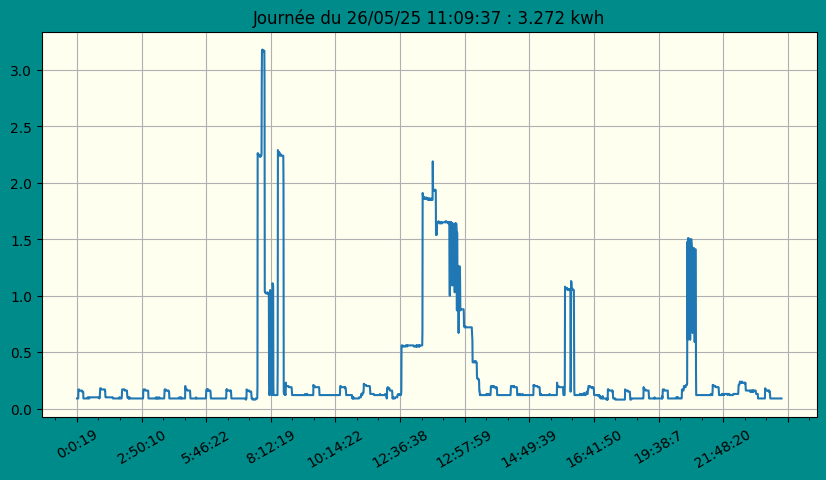

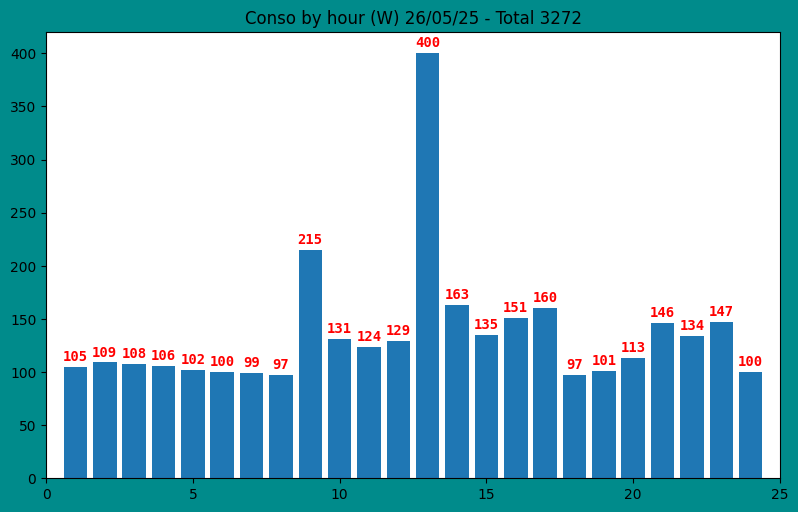

In [1323]:
# 21/04/25 cuisine midi et télé le soir 4.115 kWh
day = '26/05/25' 
day, show(day,bgcolor='ivory')
conso_by_hour(day)

22/01/25


(None, 4863)

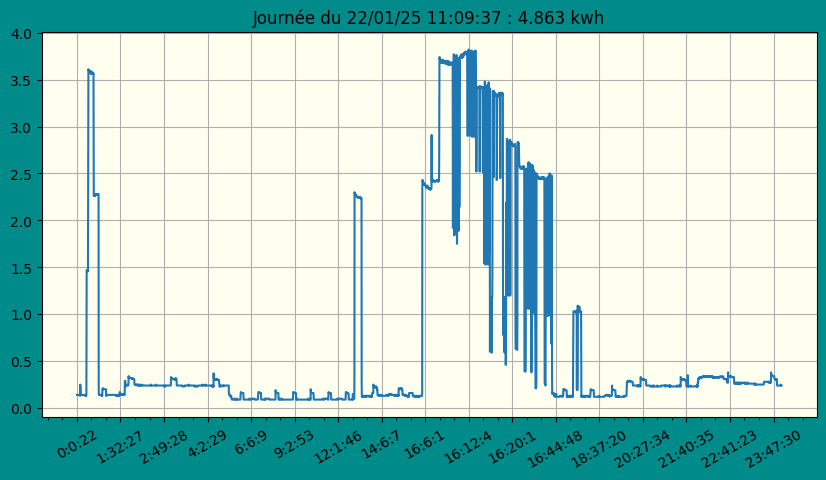

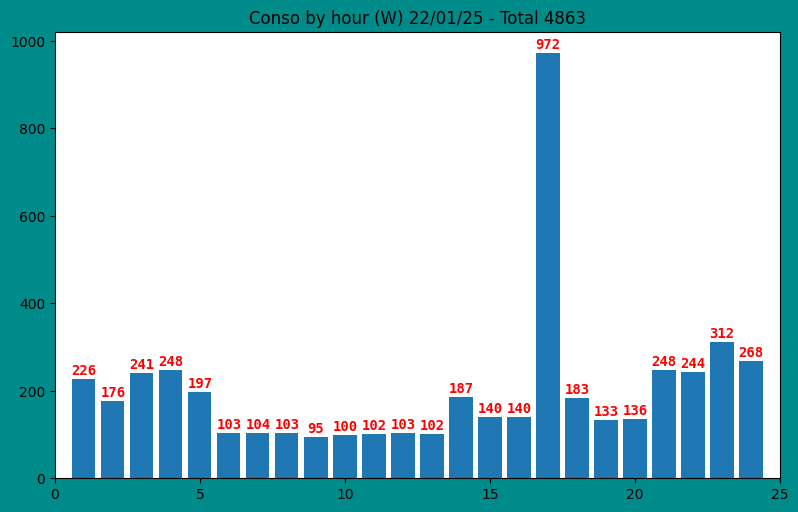

In [1324]:
print(maxday)
# retour vietnam 22/10/2024
#day = '22/10/24'
day = maxday
day, show(day,bgcolor='ivory')
conso_by_hour(day),sum(data)

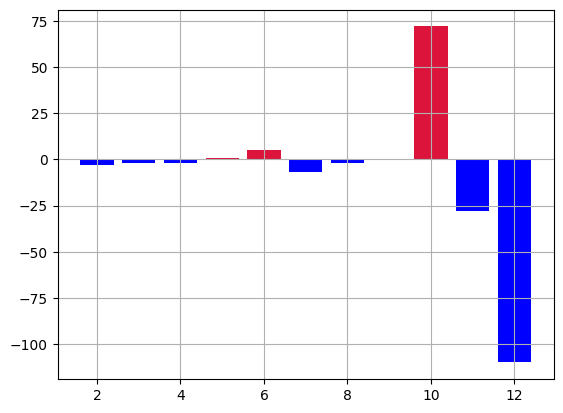

In [1325]:
diff = grp_by_dayhours.loc[today]
diff

x = np.arange(1,len(diff)+1)

plt.bar(x,diff['diff'], color=np.where(diff['diff'] > 0, 'crimson', 'blue'))
plt.grid()

<Axes: xlabel='hours'>

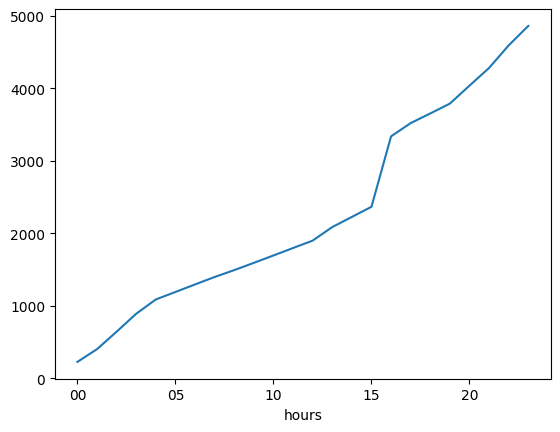

In [1326]:
data.cumsum().plot()


<Axes: xlabel='hours'>

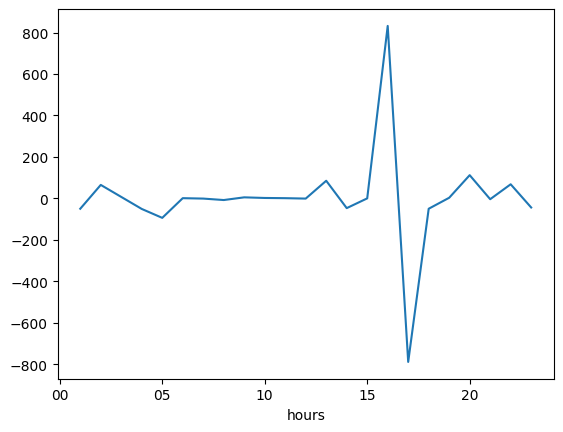

In [1327]:
# evolution par heure
data.diff().plot()

In [1328]:
data.diff().describe()

count     23.000000
mean       1.826087
std      249.001579
min     -789.000000
25%      -45.500000
50%        0.000000
75%        6.000000
max      832.000000
Name: kWh, dtype: float64

<Axes: >

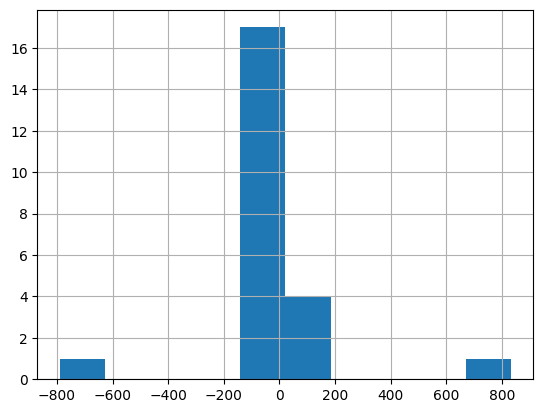

In [1329]:
data.diff().hist()

# Test sauvegarde

# list files in current directory


In [1330]:
import os
os.listdir(path='.')

['linear combination of atomic orbitals.ipynb',
 'loi_pareto.ipynb',
 'Lotka_Volterra_model.ipynb',
 'bitcoin_api.ipynb',
 'pencil_sketch.ipynb',
 'sample.json',
 'tricks.ipynb',
 'eur_vnd_change_data.ipynb',
 'pandas_course2.ipynb',
 'socket_server.ipynb',
 'tree_minmax.ipynb',
 'amlich_data.py',
 'decimals_pi_plot.ipynb',
 'conso_jour.csv',
 'Mass_Spring_Damper.jpg',
 'mills_primes.ipynb',
 'ligue1_pandas.ipynb',
 'sun_moon_paris_20250603.png',
 'isp_simulation_falcon9.ipynb',
 'primes2million.pkl',
 'socket_client.ipynb',
 'magic_tricks.ipynb',
 'magicdragon.ipynb',
 'rainbow_color.ipynb',
 'snake_game.ipynb',
 'sympy_fun.ipynb',
 'tqdm_benchmark.ipynb',
 'sun_moon_azimuth_paris_2025-06-06.png',
 'ligue1_2020_extended.txt',
 'pd_grp_plot.ipynb',
 'sun_moon_paris_20250605.png',
 'tkinter_scale_color.ipynb',
 'Dewpoint-RH-fr.svg.png',
 'read_xml.ipynb',
 'pi_from_collisions.ipynb',
 'mqtt_temp.ipynb',
 'sudoku_generator.ipynb',
 'onecall_issue.ipynb',
 'poo_chap10.ipynb',
 'de421.bsp'

# list store files csv


In [1331]:
res = []
# Iterate directory
for file in os.listdir('.'):
    # check only text files
    if file.endswith('.csv'):
        res.append(file)
        print(file)
#print(res)

conso_jour.csv
table-indicateurs-open-data-france-2023-06-30-17h59.csv
CAC40.csv
Nasdaq.csv
karaoke.csv
saturn_rings.csv
DowJones.csv
planete.csv
conso_par_jour.csv
8days.csv
SMSSpamCollection.csv
df_grp.csv
Ford.csv
Tesla.csv
Nikkei.csv
temp_humidity.csv
titanic.csv
data_temp16122022.csv
week.csv
Toyota.csv
Apple.csv
VNDUSD.csv
demain.csv
saturn_bodies.csv
conso_day_from_20230821.csv
WA_Fn-UseC_-Telco-Customer-Churn.csv
ligue1_2020_27.csv
table-indicateurs-open-data-dep-2023-06-30-17h59.csv
conso_data.csv
EURUSD.csv
df.csv


('22/01/25', None)

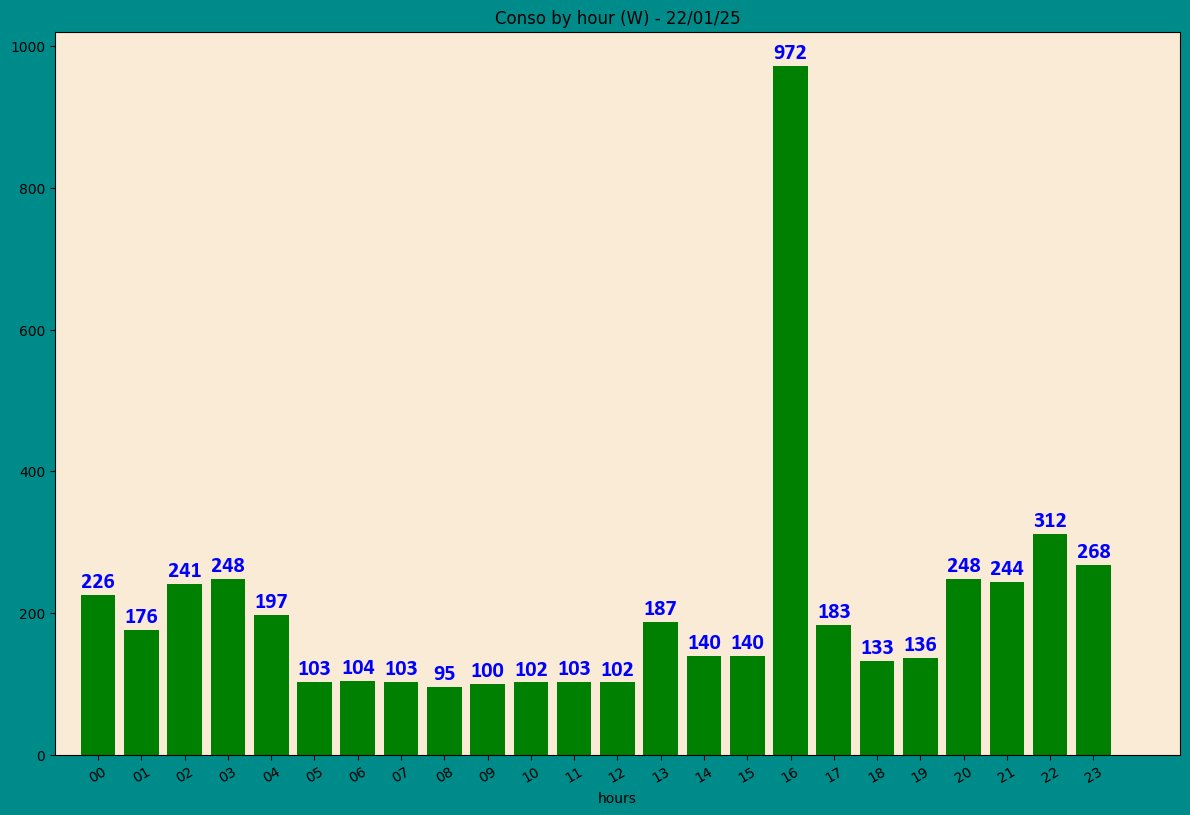

In [1332]:
day,conso_byhour(day)

In [1333]:
# save to file
import pickle
path = r'../consobyhour.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

# plot any day


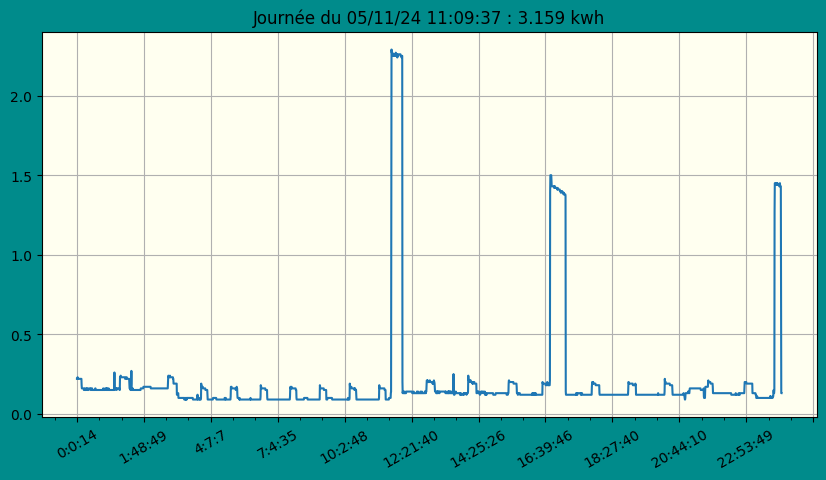

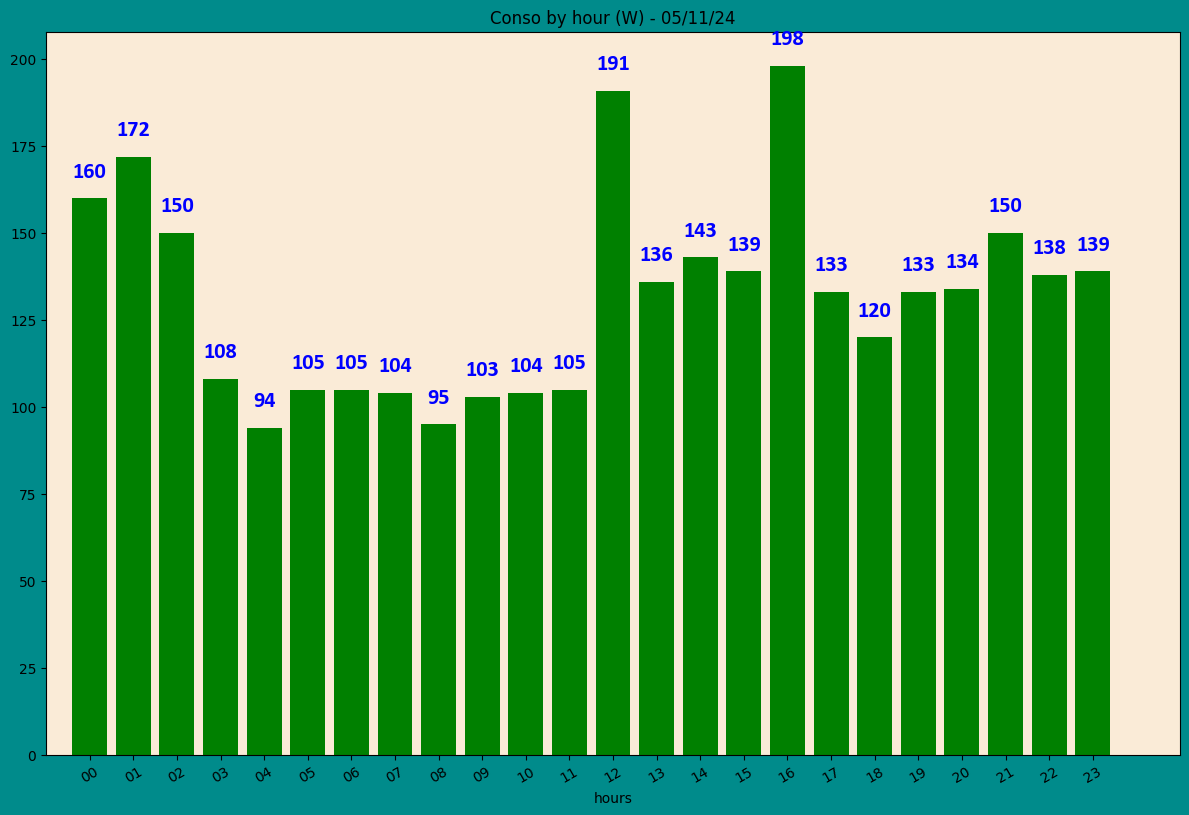

In [1334]:
day = '05/11/24'
#day = today
show(day,pltcolor='darkcyan')
conso_byhour(day)

In [1335]:
month

,day,hours,months,kWh
772310,01,00,2025-04,0.28
772311,01,00,2025-04,0.28
772312,01,00,2025-04,0.28
772313,01,00,2025-04,0.28
772314,01,00,2025-04,0.28
...,...,...,...,...
868145,30,23,2025-04,0.09
868146,30,23,2025-04,0.09
868147,30,23,2025-04,0.09
868148,30,23,2025-04,0.09


In [1336]:
month.describe()


,kWh
count,95840.000000
mean,0.310161
std,0.547863
min,0.080000
25%,0.090000
50%,0.120000
75%,0.180000
max,3.790000


<Axes: >

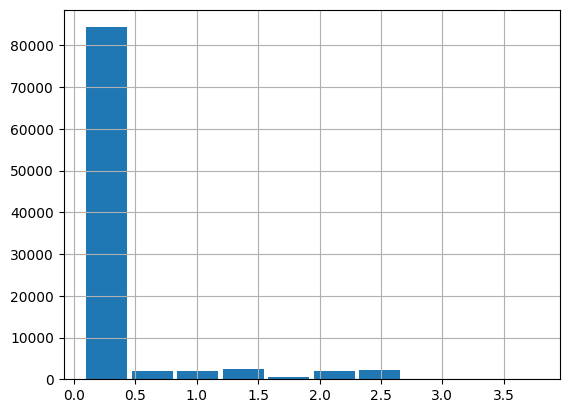

In [1337]:
# bins of conso scale by hour
month['kWh'].hist(bins=10, density=False, histtype='bar',rwidth=0.9, align='mid')

<Axes: >

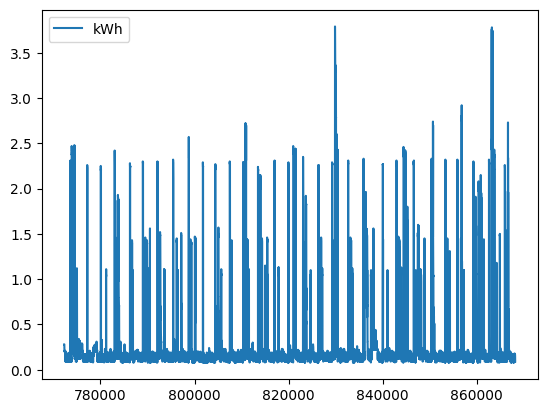

In [1338]:
month.plot()

In [1339]:
# index with max conso in this month
month.idxmax().kWh

np.int64(829855)

In [1340]:
# plot month day max conso (télévision de 11h à 23h)
day_idx = month.idxmax()
#day = '27/10/2024'
day_idx

day       865268
hours     775781
months    772310
kWh       829855
dtype: int64

In [1341]:
#show(day,pltcolor='darkcyan')
#conso_byhour(day)

In [1342]:
grp_by_dayhours

kWh  cumsum   diff  days
days     hours                          
12/08/24 07      78      78    NaN   NaN
         08     129     207   51.0   NaN
         09     122     329   -7.0   NaN
         10     120     449   -2.0   NaN
         11     180     629   60.0   NaN
...             ...     ...    ...   ...
11/06/25 07      98     824   -2.0   8.0
         08      98     922    0.0   9.0
         09     170    1092   72.0  10.0
         10     142    1234  -28.0  11.0
         11      32    1266 -110.0  12.0

[7277 rows x 4 columns]

In [1343]:
month

,day,hours,months,kWh
772310,01,00,2025-04,0.28
772311,01,00,2025-04,0.28
772312,01,00,2025-04,0.28
772313,01,00,2025-04,0.28
772314,01,00,2025-04,0.28
...,...,...,...,...
868145,30,23,2025-04,0.09
868146,30,23,2025-04,0.09
868147,30,23,2025-04,0.09
868148,30,23,2025-04,0.09


In [1344]:
month.idxmax()


day       865268
hours     775781
months    772310
kWh       829855
dtype: int64

In [1345]:
month.loc[month.idxmax().kWh]


day            19
hours          13
months    2025-04
kWh          3.79
Name: 829855, dtype: object

In [1346]:
grp_by_dayhours.loc[['28/02/25']].kWh

days      hours
28/02/25  00       182
          01       155
          02       114
          03       101
          04       109
          05       111
          06       111
          07        98
          08       110
          09       110
          10       109
          11       172
          12       145
          13       148
          14       146
          15       191
          16       144
          17       196
          18       158
          19       149
          20       143
          21       158
          22       226
          23       174
Name: kWh, dtype: int64

In [1347]:
max_hour = grp_by_dayhours.loc[['28/02/25']].kWh.idxmax()[1]
max_hour

'22'

<Axes: xlabel='days,hours'>

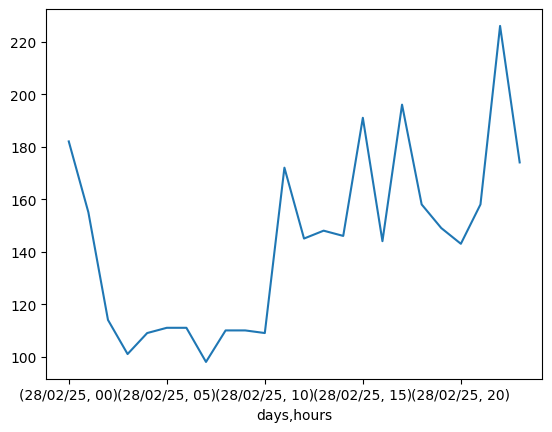

In [1348]:
grp_by_dayhours.loc[['28/02/25']].kWh.plot()#.idxmax()

In [1349]:
grp_by_dayhours.columns

Index(['kWh', 'cumsum', 'diff', 'days'], dtype='object')

In [1350]:
# diff
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['diff'],label=grp_by_dayhours.columns[2])
# plt.legend()

In [1351]:
# cumsum
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['cumsum'],label=grp_by_dayhours.columns[1])
# plt.legend()

In [1352]:
# 41 s
# file to big to git sync

# create .gitignore
filename=r'../conso_data.csv'
#conso_data.to_csv(filename)
#43.6s size 140128 kB